In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from pathlib import Path
from PIL import Image
import torch
import os

In [ ]:
model_name = 'Salesforce/blip2-flan-t5-xl-coco'
#model_name = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(model_name)

In [ ]:
device = 'cuda'

In [ ]:
model = Blip2ForConditionalGeneration.from_pretrained(
                            model_name, 
                            ).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
img_folder = Path('data/campaign2/0021')
len(os.listdir(img_folder)), os.listdir(img_folder)[:3]

(4300, ['background_0021820.exr', 'image_0021291.json', 'image_0021835.png'])

In [ ]:
def get_file_names(path, extension='.jpg'): 
    return [file_name for file_name in os.listdir(path) if file_name[-4:] == '.png']

def get_img_paths(folder_path, img_names):
     return [str(folder_path) + '/' + img_name for img_name in img_names]

In [ ]:
img_names = get_file_names(img_folder)
img_paths = get_img_paths(img_folder, img_names)
img_paths[:3]

['data/campaign2/0021/image_0021835.png',
 'data/campaign2/0021/image_0021801.png',
 'data/campaign2/0021/background_0021520.png']

In [ ]:
def get_imgs(img_paths): return [Image.open(path) for path in img_paths]

In [ ]:
ten_imgs = get_imgs(img_paths[:10])
len(ten_imgs)

10

In [ ]:
inputs = processor(images=ten_imgs, return_tensors='pt').to(device, torch.float32)

In [ ]:
generated_ids = model.generate(**inputs)
len(generated_ids)

/home/azaidi/anaconda3/envs/dl/lib/python3.10/site-packages/transformers/generation/utils.py:1284: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


10

In [ ]:
processor.batch_decode(generated_ids, skip_special_tokens=True)[-3:]

['a white and grey striped umbrella with a black hat',
 'a metal barrel sitting on the ground in a forest',
 'a barrel lying on the ground with a fire hydrant']

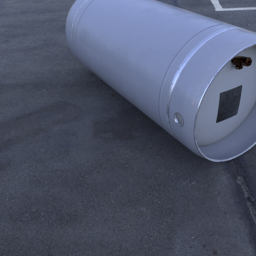

In [ ]:
ten_imgs[-1].resize((256,256))

Lets wrap it up into a function

In [ ]:
def get_lbls(images):
    inputs = processor(images=images, return_tensors='pt').to(device, torch.float32)
    generated_ids = model.generate(**inputs)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)

get_lbls(ten_imgs)

['a green barrel sitting in a field at night',
 'a green barrel sitting on the ground in a dirt lot',
 'a group of plants in wooden boxes on a sidewalk',
 'a white barrel sitting on the ground in a parking garage',
 'a white barrel sitting on the ground in a tunnel',
 'a canister flying over a forest with trees',
 'a room with a window and a gas tank',
 'a white and grey striped umbrella with a black hat',
 'a metal barrel sitting on the ground in a forest',
 'a barrel lying on the ground with a fire hydrant']

let's now setup a way to get batches of images to feed through our model, we'll then feed those batches through our get_lbl function

In [ ]:
#shows the batch indexing
batch_size = 10
[x for x in range(0, len(img_paths)+1, batch_size)][-5:]

[1060, 1070, 1080, 1090, 1100]

In [ ]:
def get_batch_idxs(img_paths, batch_size=10):
    last_idx = len(img_paths) - 1
    idxs = [x for x in range(0, len(img_paths)+1, batch_size)][:-1]
    idxs.append(last_idx)
    idx_tuples = [(idxs[x-1], idxs[x]) for x in range(1, len(idxs))]
    return idx_tuples

idxs = get_batch_idxs(img_paths[:100])
idxs, len(idxs)

([(0, 10),
  (10, 20),
  (20, 30),
  (30, 40),
  (40, 50),
  (50, 60),
  (60, 70),
  (70, 80),
  (80, 90),
  (90, 99)],
 10)

In [ ]:
def get_batch(img_paths, idx_tup): 
        return get_imgs(img_paths[idx_tup[0] : idx_tup[1]])

In [ ]:
import itertools

def run_inf(img_paths, batch_size=10):
    idxs = get_batch_idxs(img_paths)
    return list(itertools.chain(*[get_lbls(get_batch(img_paths, idx_tup)) \
                                  for idx_tup in get_batch_idxs(img_paths)]))

##that long return statement instead of 4 lines of code?
#lbls = []
#for idx_tup in get_batch_idxs(img_paths, batch_size):
#    lbls = lbls + get_lbls(get_batch(img_paths, idx_tup))
#return lbls

In [ ]:
lbls = run_inf(img_paths[:73], batch_size=25)
len(lbls), lbls[:3]

(72,
 ['a green barrel sitting in a field at night',
  'a green barrel sitting on the ground in a dirt lot',
  'a group of plants in wooden boxes on a sidewalk'])

In [ ]:
lbls[20:30]

['a metal pipe sitting on a roof in a city',
 'a large barrel sitting on the side of the road',
 'a man is riding a skateboard in a field',
 'a bus is parked in a station with a red and white sign',
 'a parking meter in a parking lot with a building in the background',
 'a blue barrel sitting on a gray background',
 'a large field with a large metal barrel in it',
 'a blue barrel sitting in the middle of a street',
 'a dirt road with a stop sign in the middle',
 'a large metal can is floating in a room that is being renovated']

## TO-DO:

- additional model support -- should be able to run this with different pre-trained models